BloomTech Data Science

*Unit 2, Sprint 1, Module 2*

---

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Module Project: Regression II

In this project, you'll continue working with the New York City rent dataset you used in the last module project.

## Directions

The tasks for this project are as follows:

- **Task 1:** Import `csv` file using `wrangle` function.
- **Task 2:** Conduct exploratory data analysis (EDA), and modify `wrangle` function to engineer two new features.
- **Task 3:** Split data into feature matrix `X` and target vector `y`.
- **Task 4:** Split feature matrix `X` and target vector `y` into training and test sets.
- **Task 5:** Establish the baseline mean absolute error for your dataset.
- **Task 6:** Build and train a `Linearregression` model.
- **Task 7:** Calculate the training and test mean absolute error for your model.
- **Task 8:** Calculate the training and test $R^2$ score for your model.
- **Stretch Goal:** Determine the three most important features for your linear regression model.

**Note**

You should limit yourself to the following libraries for this project:

- `matplotlib`
- `numpy`
- `pandas`
- `sklearn`

In [2]:
#Every Library Used In Notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2

# I. Wrangle Data

In [3]:
def wrangle(filepath):

    #Reading in the Raw Data
    df = pd.read_csv(filepath)

    #Formatting Column Names
    df.columns = df.columns.str.upper().str.replace(' ','_')

    #Declaring Subjective Wrangling Constants
    high_cardinality_percentage_threshold = 0.1
    max_cat = 5 #Max Unique Count to be Autoclassified as Categorical
    ith_identifier_as_index = -1 #0-indexed, set as -1 to not change index

    #Column Classification Lists (initialize as needed)
    date_cols = ['CREATED']
    categorical_cols = [] #Most Will Be Automatically Detected

    #Column Classifications (no initialization needed)
    numerical_cols = []
    high_card_cols = []
    single_value_cols = []
    identifier_cols = []

    for col in df:

      #print(col, df[col].dtype, df[col].nunique())

      #Find Categorical/Numerical Variables
      if (df[col].dtype == 'object' or (df[col].nunique() in range(2,max_cat+1) )):
        #print("Column: ",col)
        if ~(col in categorical_cols):
          categorical_cols.append(col)
      else:
        if ~(col in numerical_cols+categorical_cols):
          numerical_cols.append(col)

      #Format Dates
      if( (col in categorical_cols) and (col in date_cols)):
        df[col] = pd.to_datetime(df[col])

      #Find Indentifier Variables
      if ( (df[col].nunique() == df.shape[0]) and (col in categorical_cols) ):
        identifier_cols.append(col)

      #Find Columns With Only One Value
      if df[col].nunique() == 1:
        if ~(col in single_value_cols):
          single_value_cols.append(col)

      #Find Columns With High Cardinality (Categorical Variables With Too Many Categories)
      if ( (col in categorical_cols) and ~(col in identifier_cols) and
          (df[col].nunique() / df.shape[0] > high_cardinality_percentage_threshold) ):
        high_card_cols.append(col)
    
    #Set ith Identifier as New Index
    if len(identifier_cols) > 0 and ith_identifier_as_index != -1:
      df = df.set_index(identifier_cols[ith_identifier_as_index])
      print('New Index: ', identifier_cols[ith_identifier_as_index])
      identifier_cols.remove(identifier_cols[ith_identifier_as_index])

    #Output Column Classifications
    # print('Numerical Cols:', numerical_cols)
    # print('Categorical Cols:', categorical_cols)
    # print()
    # print('Identifier Cols:', identifier_cols)
    # print('Single Valued Cols:', single_value_cols)
    # print('High Cardinality Cols:', high_card_cols)
   
    #Drop All Rows With Null Values
    df = df.dropna(axis=0)

    #Drop Columns
    cols_to_drop = single_value_cols + high_card_cols
    #print('Columns To Drop:', cols_to_drop)
    #df = df.drop(cols_to_drop, axis=1)

    # Remove the most extreme 1% prices,
    # the most extreme 1% latitudes, &
    # the most extreme 1% longitudes
    df = df[(df['PRICE'] >= np.percentile(df['PRICE'], 0.5)) & 
            (df['PRICE'] <= np.percentile(df['PRICE'], 99.5)) & 
            (df['LATITUDE'] >= np.percentile(df['LATITUDE'], 0.05)) & 
            (df['LATITUDE'] < np.percentile(df['LATITUDE'], 99.95)) &
            (df['LONGITUDE'] >= np.percentile(df['LONGITUDE'], 0.05)) & 
            (df['LONGITUDE'] <= np.percentile(df['LONGITUDE'], 99.95))]

    return df

filepath = DATA_PATH + 'apartments/renthop-nyc.csv'

df = df = wrangle(filepath)

Columns To Drop: ['CREATED', 'DESCRIPTION', 'DISPLAY_ADDRESS', 'STREET_ADDRESS']


In [5]:
df['DISPLAY_ADDRESS'].nunique()

8552

In [6]:
df['STREET_ADDRESS'].nunique()

14635

In [4]:
#THERE ARE REPEAT DATES
#df[ df['CREATED'].duplicated() ]

cols_to_drop = ['CREATED', 'DESCRIPTION', 'DISPLAY_ADDRESS', 'STREET_ADDRESS']

**Task 1:** Add the following functionality to the above `wrangle` function.

- The `'created'` column will parsed as a `DateTime` object and set as the `index` of the DataFrame. 
- Rows with `NaN` values will be dropped.

Then use your modified function to import the `renthop-nyc.csv` file into a DataFrame named `df`.

**Task 2:** Using your `pandas` and dataviz skills decide on two features that you want to engineer for your dataset. Next, modify your `wrangle` function to add those features. 

**Note:** You can learn more about feature engineering [here](https://en.wikipedia.org/wiki/Feature_engineering). Here are some ideas for new features:

- Does the apartment have a description?
- Length of description.
- Total number of perks that apartment has.
- Are cats _or_ dogs allowed?
- Are cats _and_ dogs allowed?
- Total number of rooms (beds + baths).

In [7]:
print(list(df.columns))

['BATHROOMS', 'BEDROOMS', 'CREATED', 'DESCRIPTION', 'DISPLAY_ADDRESS', 'LATITUDE', 'LONGITUDE', 'PRICE', 'STREET_ADDRESS', 'INTEREST_LEVEL', 'ELEVATOR', 'CATS_ALLOWED', 'HARDWOOD_FLOORS', 'DOGS_ALLOWED', 'DOORMAN', 'DISHWASHER', 'NO_FEE', 'LAUNDRY_IN_BUILDING', 'FITNESS_CENTER', 'PRE-WAR', 'LAUNDRY_IN_UNIT', 'ROOF_DECK', 'OUTDOOR_SPACE', 'DINING_ROOM', 'HIGH_SPEED_INTERNET', 'BALCONY', 'SWIMMING_POOL', 'NEW_CONSTRUCTION', 'TERRACE', 'EXCLUSIVE', 'LOFT', 'GARDEN_PATIO', 'WHEELCHAIR_ACCESS', 'COMMON_OUTDOOR_SPACE']


LIVABILITY
0    3524.970891
1    3855.860052
2    4639.397741
Name: PRICE, dtype: float64



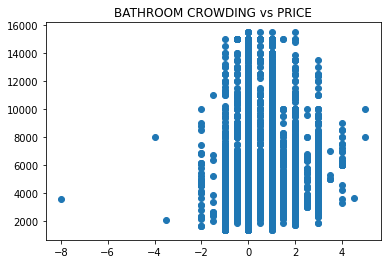

In [8]:
# Conduct your exploratory data analysis here, 
# and then modify the function above.

# Feature Formatting
df.loc[df['INTEREST_LEVEL'] == 'low', "INTEREST_LEVEL"] = 0
df.loc[df['INTEREST_LEVEL'] == 'medium', "INTEREST_LEVEL"] = 1
df.loc[df['INTEREST_LEVEL'] == 'high', "INTEREST_LEVEL"] = 2

# Additional Feature #1
df['BATHROOM_CROWDING'] = df['BEDROOMS'] - df['BATHROOMS']
plt.title('BATHROOM CROWDING vs PRICE')
plt.scatter(y=df['PRICE'], x=df['BATHROOM_CROWDING']);

# Additional Feature #2
df['LIVABILITY'] = df['HIGH_SPEED_INTERNET']*(df['DISHWASHER'] + df['LAUNDRY_IN_UNIT'])
print(df.groupby(by='LIVABILITY')['PRICE'].mean()); print()
#plt.scatter(y=df['PRICE'], x=df['LIVABLE']);

# plt.scatter(y=df['PRICE'], x=df['DOGS_ALLOWED']);
# print(df.groupby(by='DOGS_ALLOWED')['PRICE'].mean()); print()

# II. Split Data

**Task 3:** Split your DataFrame `df` into a feature matrix `X` and the target vector `y`. You want to predict `'price'`.

**Note:** In contrast to the last module project, this time you should include _all_ the numerical features in your dataset.

In [11]:
target = 'PRICE'
features = list(df.columns)
for col in cols_to_drop:
  features.remove(col)
features.remove(target)

X = df[ features ]
y = df[target]

**Task 4:** Split `X` and `y` into a training set (`X_train`, `y_train`) and a test set (`X_test`, `y_test`).

- Your training set should include data from April and May 2016. 
- Your test set should include data from June 2016.

In [12]:
mask = ( (df['CREATED'].dt.month == 4) | (df['CREATED'].dt.month == 5) )

X_train, y_train = X.loc[mask], y.loc[mask]
X_test, y_test = X.loc[~mask], y.loc[~mask]

#print(df[~mask]['CREATED'].dt.month.value_counts()) #To Check That The Split Worked

# III. Establish Baseline

**Task 5:** Since this is a **regression** problem, you need to calculate the baseline mean absolute error for your model. First, calculate the mean of `y_train`. Next, create a list `y_pred` that has the same length as `y_train` and where every item in the list is the mean. Finally, use `mean_absolute_error` to calculate your baseline.

In [13]:
y_pred_baseline = [ y_train.mean() ] * len(y_train)
baseline_mae = mae(y_train, y_pred_baseline)
print('Baseline MAE:', baseline_mae)

Baseline MAE: 1202.398300781848


# IV. Build Model

**Task 6:** Build and train a `LinearRegression` model named `model` using your feature matrix `X_train` and your target vector `y_train`.

In [14]:
model = LinearRegression()

model.fit(X_train, y_train)


LinearRegression()

# V. Check Metrics

**Task 7:** Calculate the training and test mean absolute error for your model.

In [15]:
training_mae = mae(y_train, model.predict(X_train))
test_mae = mae(y_test, model.predict(X_test))

print('Training MAE:', training_mae)
print('Test MAE:', test_mae)

Training MAE: 672.8995195838064
Test MAE: 676.3613903051682


**Task 8:** Calculate the training and test $R^2$ score for your model.

In [16]:
training_r2 = r2(y_train, model.predict(X_train))
test_r2 = r2(y_train, model.predict(X_train))

print('Training R2:', training_r2)
print('Test R2:', test_r2)

Training R2: 0.6360223007864619
Test R2: 0.6360223007864619


# VI. Communicate Results

**Stretch Goal:** What are the three most influential coefficients in your linear model? You should consider the _absolute value_ of each coefficient, so that it doesn't matter if it's positive or negative.

In [24]:
var = 'ABS COEF'
coef_df = pd.DataFrame(model.coef_, index=features, columns=[var])
print(coef_df.abs().sort_values(by=var, ascending=False))

                          ABS COEF
BATHROOMS             1.172889e+15
BATHROOM_CROWDING     1.172889e+15
BEDROOMS              1.172889e+15
LONGITUDE             1.306342e+04
LATITUDE              1.222697e+03
LAUNDRY_IN_UNIT       4.851853e+02
DOORMAN               4.226043e+02
INTEREST_LEVEL        4.115810e+02
HIGH_SPEED_INTERNET   2.678594e+02
DINING_ROOM           2.657656e+02
EXCLUSIVE             2.127041e+02
WHEELCHAIR_ACCESS     1.820430e+02
TERRACE               1.810938e+02
ROOF_DECK             1.608666e+02
HARDWOOD_FLOORS       1.454537e+02
COMMON_OUTDOOR_SPACE  1.367959e+02
ELEVATOR              1.345593e+02
LOFT                  1.335400e+02
NEW_CONSTRUCTION      1.310117e+02
LAUNDRY_IN_BUILDING   1.089525e+02
FITNESS_CENTER        1.088985e+02
NO_FEE                1.030957e+02
PRE-WAR               9.024763e+01
OUTDOOR_SPACE         8.050000e+01
DOGS_ALLOWED          7.221642e+01
SWIMMING_POOL         6.303906e+01
DISHWASHER            5.879296e+01
BALCONY             